![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 11 - RNN </center>
### <center> Advanced RNN </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/11_RNN/MainAdvancedRNN.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt

import torch
import torch.nn    as nn
import torch.optim as optim
import torchsummary
import torchtext

from torchtext.data.utils import get_tokenizer
from torchtext.vocab      import Vocab
from torchtext.datasets   import IMDB

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/10_RNN/DeepLearningFramework ./DeepLearningFramework

### Stacked RNN
<img src="https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/10_RNN//StackedRNN.png?raw=true" style="width: 700px;"/>

In [9]:
T       = 5
D       = 8
H       = 16
nLayers = 3
N       = 128

mX      = torch.randn(T, N, D)

oRNN    = nn.RNN(D, H, num_layers=nLayers)
mO, mH  = oRNN(mX)

mO.shape, mH.shape

(torch.Size([5, 128, 16]), torch.Size([3, 128, 16]))

### GRU

In [10]:
oGRU   = nn.GRU(D, H)
mO, mH = oGRU(mX)

mO.shape, mH.shape

(torch.Size([5, 128, 16]), torch.Size([1, 128, 16]))

### LSTM

In [11]:
oLSTM        = nn.LSTM(D, H)
mO, (mH, mC) = oLSTM(mX)

mO.shape, mH.shape, mC.shape

(torch.Size([5, 128, 16]), torch.Size([1, 128, 16]), torch.Size([1, 128, 16]))

### Bidirectional RNN
`mO.shape` = $(T, N, 2H)$ (forward and backward are concatenated).  
`mH.shape` = $(2, N, H)$.  
`mH[0]` is the forward hidden state.  
`mH[1]` is the backward hidden state.  

In [12]:
oRNN   = nn.RNN(D, H, bidirectional=True)
mO, mH = oRNN(mX)

mO.shape, mH.shape

(torch.Size([5, 128, 32]), torch.Size([2, 128, 16]))

### Put it all together
A bidirectional GRU unit with `nLayers = 3`:

`mO.shape` = $(T, N, 2H)$ (forward and backward are concatenated).  
`mH.shape` = $(2L, N, H)$.  
`mH[0]` is the forward hidden state of layer 1.  
`mH[1]` is the backward hidden state of layer 1.  
`mH[2]` is the forward hidden state of layer 2.  
`mH[3]` is the backward hidden state of layer 2.  
`mH[4]` is the forward hidden state of layer 3.  
`mH[5]` is the backward hidden state of layer 3.  

In [13]:
oGRU   = nn.GRU(D, H, num_layers=3, bidirectional=True)
mO, mH = oGRU(mX)

mO.shape, mH.shape

(torch.Size([5, 128, 32]), torch.Size([6, 128, 16]))

### Exercise:
* Use the advanced units and get above 85% accuracy on the sentiment analysis task.  
* (Keep all sequences with less than 150 words.)

In [14]:
dirPath             = '../../data'
oTokenizer          = get_tokenizer('basic_english')

trainIter, testIter = IMDB(root=dirPath)

In [15]:
def NumWords(line):
    return len(line.split())

maxLength = 150
lTrainSet = [(label, line) for (label, line) in trainIter if NumWords(line) < maxLength]
lTestSet  = [(label, line) for (label, line) in testIter  if NumWords(line) < maxLength]

In [16]:
len(trainIter), len(testIter), len(lTrainSet), len(lTestSet)

(25000, 25000, 9746, 9932)

In [17]:
import random

red   = '\x1b[31m'
green = '\x1b[32m'
end   = '\x1b[0m'

for _  in range(3):
    (label, line) = random.choice(lTrainSet)
    
    color = red if label == 'neg' else green
    print('=========================================================================================================')
    print('=========================================================================================================')
    print(color + line + end)
    print('--Tokenized:---------------------------')    
    print(oTokenizer(line))

this movie was terrible. i thought with all the some what decent actors, it would be better. don't waste your time. Eva longoria parker was awful. she should stick to desperate housewives. Paul Rudd is becoming a B actor. the mess he made in the movie i could never be your woman was the epitome of what i'm saying. and lake bell she was cute but definitely in need of some more acting lessons. watch just like heaven with Reese Witherspoon...it was a tad better. or any other ghost movie. you will be grateful to not have wasted your precious time. PS i love you is also a good from beyond the grave romance! time to start watching movies rated over 7 out of 10 and listen to the people who have already seen it.
--Tokenized:---------------------------
['this', 'movie', 'was', 'terrible', '.', 'i', 'thought', 'with', 'all', 'the', 'some', 'what', 'decent', 'actors', ',', 'it', 'would', 'be', 'better', '.', 'don', "'", 't', 'waste', 'your', 'time', '.', 'eva', 'longoria', 'parker', 'was', 'awful

In [18]:
from torchtext.vocab import build_vocab_from_iterator

def YieldTokens(lDataset):
    for (label, line) in lDataset:
        yield oTokenizer(line)

oVocab = build_vocab_from_iterator(YieldTokens(lTrainSet), min_freq=5, specials=('<UNK>', '<SOS>', '<EOS>', '<PAD>'))
oVocab.set_default_index(oVocab['<UNK>'])
len(oVocab)

10450

In [19]:
def Text2Tensor(line):
    return torch.tensor([oVocab['<BOS>']] + [oVocab[token] for token in oTokenizer(line)] + [oVocab['<EOS>']])

def Label2Int(label):
    if label == 'pos':
        return 1
    else:
        return 0

# Print out the output of text_transform
line = 'Hello World!'
print('Input :', line)
print('Output:', Text2Tensor(line))

Input : Hello World!
Output: tensor([   0, 3630,  212,   25,    2])


In [42]:
from torch.utils.data   import DataLoader
from torch.nn.utils.rnn import pack_sequence

def CollateBatch(lBatch):
    ???

    return mPackX, vY

In [43]:
batchSize = 128
oTrainDL  = DataLoader(lTrainSet, batch_size=batchSize,   shuffle=True, collate_fn=CollateBatch)
oTestDL   = DataLoader(lTestSet,  batch_size=2*batchSize, shuffle=True, collate_fn=CollateBatch)

In [44]:
from torch.nn.utils.rnn import PackedSequence

def PackedAs(mX, mPack):
    return PackedSequence(mX, mPack.batch_sizes, None, mPack.unsorted_indices)

V = len(oVocab)
D = 24
H = 16
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        ???
        
    def forward(self, mPackX):
        ???

In [45]:
mX, vY = next(iter(oTrainDL))
RNN()(mX).shape

torch.Size([128])

In [46]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = nn.BCEWithLogitsLoss()

In [49]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Metric   import BinaryAcuuracy
from DeepLearningFramework.Training import TrainModel

nEpochs       = 50
nIter         = nEpochs * len(oTrainDL)

oModel        = RNN        ().to(DEVICE)
oOptim        = ???
oScheduler    = ???
lHistory      = TrainModel (oModel, oTrainDL, oTestDL, Loss, BinaryAcuuracy, nEpochs, oOptim, oScheduler);

SyntaxError: invalid syntax (<ipython-input-49-c6928ceb4427>, line 8)

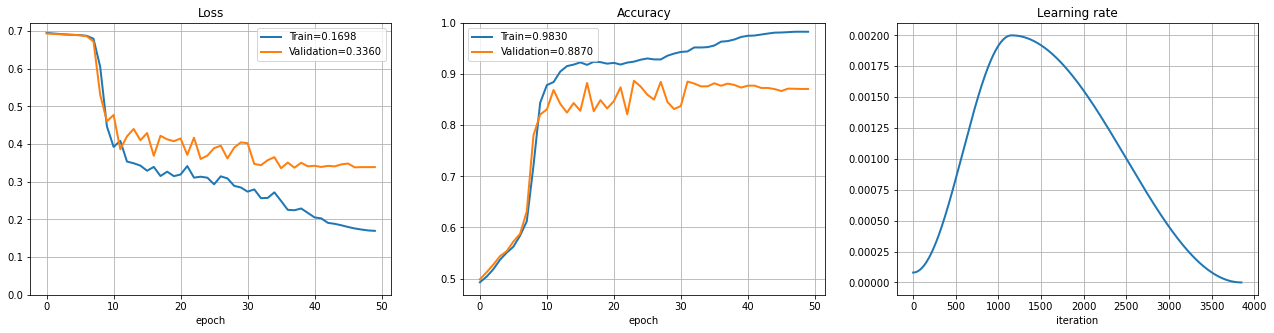

In [48]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)